In [8]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  4 15:40:40 2019

@author: Ethan
"""
exec(open("../util/setupConsole.py").read())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
import el_build_temp_pp_model
import gzip, pickle
import sys

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/electricity'

plotFigs = False

# only show values on the surface that have historically occurred
onlyShowObs = False

tempVar = 'txSummer'
qsVar = 'qsGrdcAnomSummer'

pcVal = -2
fuelVal = -2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# load historical weather data for plants to compute mean temps 
# to display on bootstrap temp curve
fileName = '%s/script-data/entsoe-nuke-pp-tx-1981-2018.csv'%dataDirDiscovery
plantTxData = np.genfromtxt(fileName, delimiter=',', skip_header=0)
plantYearData = plantTxData[0,:].copy()
plantMonthData = plantTxData[1,:].copy()
plantDayData = plantTxData[2,:].copy()
plantTxData = plantTxData[3:,:].copy()

fileName = '%s/script-data/entsoe-nuke-pp-runoff-anom-gldas-1981-2018.csv'%dataDirDiscovery
plantQsData = np.genfromtxt(fileName, delimiter=',', skip_header=0)
plantQsData = plantQsData[3:,:]

summerInd = np.where((plantMonthData == 7) | (plantMonthData == 8))[0]
plantMeanTemps = np.nanmean(plantTxData[:,summerInd], axis=1)
plantMeanRunoff = np.nanmean(plantQsData[:,summerInd], axis=1)

with gzip.open('%s/script-data/ppFutureTxQsData.dat'%dataDirDiscovery, 'rb') as f:
    ppFutureData = pickle.load(f)
#     txHist = np.nanmean(np.nanmean(ppFutureData['txMonthlyMax'][:,[6,7]]))
#     qsHist = np.nanmean(np.nanmean(ppFutureData['qsAnomMonthlyMean'][:,[6,7]]))
    tx2 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['txMonthlyMaxFutGMT'][1,:,:,[6,7]])))
    tx4 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['txMonthlyMaxFutGMT'][3,:,:,[6,7]])))
    qs2 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['qsMonthlyMeanFutGMT'][1,:,:,[6,7]])))
    qs4 = np.nanmean(np.nanmean(np.nanmean(ppFutureData['qsMonthlyMeanFutGMT'][3,:,:,[6,7]])))

In [10]:
if 'percentile' in qsVar.lower():
    qsrange = np.linspace(0, 1, 25)
else:
    qsrange = np.linspace(-4, 4.1, 25)
txrange = np.linspace(27, 51, 25)

histPDF = np.zeros([len(qsrange), len(txrange)])
histStipple = np.zeros([len(qsrange), len(txrange)])

for q, qs in enumerate(qsrange):
    for t, tx in enumerate(txrange):
        ind = np.where((plantTxData >= tx-.5) & (plantTxData <= tx+.5) & \
                       (plantQsData >= qs-.25) & (plantQsData <= qs+.25))[0]
        if len(ind) > 0:
            histPDF[q,t] = 1
        else:
            histPDF[q,t] = 0
        
        if len(ind) > 100:
            histStipple[q,t] = 1

print('building models')
models, plantIds, plantCooling, plantFuel, plantAge, plantUSorEU, plantYears, plantTxData, plantQsData = el_build_temp_pp_model.buildNonlinearTempQsPPModel(tempVar, qsVar, 1)

ind = np.where(plantIds > 0)[0]
plantIds = plantIds[ind]
plantYears = plantYears[ind]
if pcVal == -2:
    plantCooling = plantCooling[ind]
else:
    plantCooling = [pcVal]*len(ind)
plantFuel = plantFuel[ind]
plantAge = plantAge[ind]

building models
0% complete


In [11]:
# plantIdsTmp = np.unique(plantIds)
# plantIds = np.array(list(np.unique(plantIds))*len(np.unique(plantYears)))
# tmp = []
# for p in np.unique(plantYears):
#     tmp.extend([p]*len(plantIdsTmp))
# plantYears = np.array(tmp)

yds = np.zeros([len(models), len(qsrange), len(txrange)])
yds[yds == 0] = np.nan

print('calculating surface')
for m in range(len(models)):    
    print('processing model %d of %d'%(m+1,len(models)))
    for q in range(len(qsrange)):
        for t in range(len(txrange)):
            
            if histPDF[q,t] == 1 or not onlyShowObs:
                dfpred = pd.DataFrame({'T1':[txrange[t]]*len(plantIds), 'T2':[txrange[t]**2]*len(plantIds), \
                         'QS1':[qsrange[q]]*len(plantIds), 'QS2':[qsrange[q]**2]*len(plantIds), \
                         'QST':[txrange[t]*qsrange[q]]*len(plantIds), 'QS2T2':[(txrange[t]**2)*(qsrange[q]**2)]*len(plantIds), \
                         'PlantIds':plantIds, 'PlantYears':plantYears, 'PlantCooling':plantCooling, 'PlantFuel':plantFuel, 'PlantAge':plantAge})

                yds[m,q,t] = np.nanmean(models[m].predict(dfpred))
            else:
                yds[m,q,t] = np.nan
        
yds = np.array(yds)
yds = np.squeeze(np.nanmedian(yds, axis=0))

minVal = 80

yds[yds<minVal] = minVal

calculating surface
processing model 1 of 1


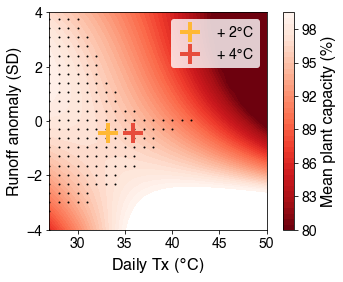

In [12]:
snsColors = sns.color_palette(["#3498db", "#e74c3c"])

    
plt.contourf(txrange, qsrange, yds, levels=np.arange(minVal,100,.5), cmap = 'Reds_r')
cb = plt.colorbar()
cb.set_ticks(range(minVal,100,3))
plt.xlim([27,50])
if 'percentile' in qsVar.lower():
    plt.ylim([0,1])
else:
    plt.ylim([-4,4])
plt.plot([27, 50], [np.nanmean(plantMeanRunoff), np.nanmean(plantMeanRunoff)], '-k', lw=2)
# plt.plot([txHist, txHist], [-4, 4], '-k', lw=2)

for q in range(len(qsrange)):
    for t in range(len(txrange)):
        if histStipple[q, t] == 1:
            plt.plot(txrange[t], qsrange[q], 'ok', markersize=1)

#plt.plot(txHist, qsHist, '+k', markersize=20, mew=4, lw=2)
plt.plot(tx2, qs2, '+k', markersize=20, mew=4, lw=2, color='#ffb835', label='+ 2$\degree$C')
plt.plot(tx4, qs4, '+k', markersize=20, mew=4, lw=2, color=snsColors[1], label='+ 4$\degree$C')

# plt.xticks(txrange)
# plt.yticks(qsrange)
plt.xlabel('Daily Tx ($\degree$C)', fontname = 'Helvetica', fontsize=16)
plt.ylabel('Runoff anomaly (SD)', fontname = 'Helvetica', fontsize=16)
# plt.ylabel('Runoff percentile', fontname = 'Helvetica', fontsize=16)
cb.set_label('Mean plant capacity (%)', fontname = 'Helvetica', fontsize=16)

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')
    tick.label.set_fontsize(14)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontname('Helvetica')    
    tick.label.set_fontsize(14)
for tick in cb.ax.yaxis.get_ticklabels():
    tick.set_fontname('Helvetica')    
    tick.set_fontsize(14)

leg = plt.legend(prop = {'size':14, 'family':'Helvetica'}, loc = 'upper right')
leg.get_frame().set_linewidth(0.0)

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()
plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

if plotFigs:
    plt.savefig('hist-pc-%s-%s-regression-contour-pcVal-%d.png'%(tempVar,qsVar,pcVal), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
